<a href="https://colab.research.google.com/github/sergmasl/a_b_tests_scripts/blob/main/a_b_test_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
# Initial empty cell. Can be used for imports or setup.


In [98]:
# This cell initializes the Google Cloud BigQuery client, authenticates the Colab environment,
# and sets the project ID for subsequent BigQuery operations.
# Install the Google Cloud BigQuery client library if not already installed
!pip install google-cloud-bigquery

# Import necessary libraries
from google.cloud import bigquery
from google.colab import auth

# Authenticate your Colab environment
# This will prompt you to log in to your Google account and grant permissions.
print("Authenticating user...")
auth.authenticate_user()
print("User authenticated.")

# Define the BigQuery project ID
project_id = 'endel-analytics'

# Create a BigQuery client for the specified project
client = bigquery.Client(project=project_id)

print(f"Successfully connected to BigQuery project: {client.project}")

Authenticating user...
User authenticated.
Successfully connected to BigQuery project: endel-analytics


In [99]:
# This cell constructs and executes a BigQuery SQL query to fetch A/B test data
# from the specified tables and loads the results into a Pandas DataFrame named `df`.
import pandas as pd

# Construct the SQL query
# Use CURRENT_DATE() to get the current date and DATE_SUB to subtract 10 days
query = f"""
WITH
table_labels as (
SELECT DISTINCT canonical_user_id as user_id,  exp_flowScreensSlot20 as label
FROM `endel-analytics.endel_data.v5_a_b_labels_new_users`
WHERE event_date BETWEEN '2026-01-08' AND '2026-01-20'
AND exp_flowScreensSlot20 IN ('"Catalog Fragments: text2sound Freemium [A]"', '"Catalog Fragments: text2sound Freemium [B]"')
)
SELECT table_labels.label, table_labels.user_id, user_info.conversion_day0,
user_info.conversion_day7, user_info.conversion_rcat_trial_started_day0,
user_info.arpu_day0, user_info.arpu_day7,
user_info.retention_day1, user_info.retention_day7,
FROM table_labels LEFT JOIN `endel-analytics.endel_data.v5_user_info` user_info
ON table_labels.user_id = user_info.user_id
AND user_creation_date BETWEEN '2026-01-08' AND '2026-01-20'
"""

print(f"Executing BigQuery query")

# Run the query and convert results to a pandas DataFrame
try:
    query_job = client.query(query)
    df = query_job.to_dataframe()

    print("Query successful")

except Exception as e:
    print(f"Error executing BigQuery query: {e}")
    print("Please ensure the table path is correct and your account has appropriate BigQuery permissions (e.g., bigquery.dataViewer on the dataset).")

Executing BigQuery query
Query successful


In [100]:
# This cell removes rows with any missing (NA) values from the DataFrame to ensure data quality.
df_cleaned = df.dropna()
print("DataFrame after removing NA values:")

DataFrame after removing NA values:


In [97]:
# This cell cleans the 'label' column by removing quotes and stripping whitespace.
# It then identifies users who were inadvertently assigned to both Group A and Group B.
df_cleaned['label'] = df_cleaned['label'].str.replace('"', '', regex=False).str.strip()

# Separate users by group
users_group_a = df_cleaned[df_cleaned['label'].str.contains('[A]', regex=False)]['user_id'].unique()
users_group_b = df_cleaned[df_cleaned['label'].str.contains('[B]', regex=False)]['user_id'].unique()

# Find users present in both groups (overlap)
overlap_users = pd.Series(list(set(users_group_a) & set(users_group_b)))

print(f"Number of users in Group A: {len(users_group_a)}")
print(f"Number of users in Group B: {len(users_group_b)}")
print(f"Number of users in both groups (overlap): {len(overlap_users)}")

if not overlap_users.empty:
    print("Users found in both groups (first 5):")
else:
    print("No users found in both groups.")

Number of users in Group A: 26568
Number of users in Group B: 26651
Number of users in both groups (overlap): 106
Users found in both groups (first 5):


/tmp/ipython-input-2032176743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['label'] = df_cleaned['label'].str.replace('"', '', regex=False).str.strip()


In [101]:
# This cell removes any identified overlapping users from the DataFrame
# and then splits the data into two separate DataFrames, 'group_a' and 'group_b'.
df_cleaned = df_cleaned[~df_cleaned['user_id'].isin(overlap_users)]

# Standardize the 'label' column by removing quotes and stripping whitespace
df_cleaned.loc[:, 'label'] = df_cleaned['label'].str.replace('"', '', regex=False).str.strip()

# Split the cleaned DataFrame into Group A and Group B based on containment
group_a = df_cleaned[df_cleaned['label'].str.contains('[A]', regex=False)]
group_b = df_cleaned[df_cleaned['label'].str.contains('[B]', regex=False)]

print(f"DataFrame after removing overlapping users. Remaining users in Group A: {len(group_a['user_id'].unique())}")
print(f"DataFrame after removing overlapping users. Remaining users in Group B: {len(group_b['user_id'].unique())}")
print("Data split into group_a and group_b DataFrames.")

DataFrame after removing overlapping users. Remaining users in Group A: 26462
DataFrame after removing overlapping users. Remaining users in Group B: 26545
Data split into group_a and group_b DataFrames.


In [85]:
# This cell defines the `bootstrap_ab_test` function to perform A/B testing.
# It then applies this function to all specified metrics, calculates raw p-values,
# and applies Benjamini-Hochberg (FDR) correction for multiple comparisons.
import numpy as np
from statsmodels.stats.multitest import multipletests

def bootstrap_ab_test(data_a, data_b, metric_name, n_bootstraps=10000, alpha=0.05):
    """
    Performs a bootstrap A/B test for a given metric.

    Args:
        data_a (pd.Series): Data for Group A for the specified metric.
        data_b (pd.Series): Data for Group B for the specified metric.
        metric_name (str): The name of the metric being tested.
        n_bootstraps (int): Number of bootstrap iterations.
        alpha (float): Significance level for confidence interval.

    Returns:
        dict: A dictionary containing the test results.
    """
    # Calculate observed means and difference
    mean_a = data_a.mean()
    mean_b = data_b.mean()
    observed_diff = mean_b - mean_a

    boot_diffs = []
    for _ in range(n_bootstraps):
        # Bootstrap samples with replacement
        boot_sample_a = np.random.choice(data_a, size=len(data_a), replace=True)
        boot_sample_b = np.random.choice(data_b, size=len(data_b), replace=True)

        # Calculate bootstrap means
        boot_mean_a = np.mean(boot_sample_a)
        boot_mean_b = np.mean(boot_sample_b)

        # Store the difference
        boot_diffs.append(boot_mean_b - boot_mean_a)

    # Calculate confidence interval
    lower_ci = np.percentile(boot_diffs, (alpha / 2) * 100)
    upper_ci = np.percentile(boot_diffs, (1 - alpha / 2) * 100)

    # Calculate two-sided p-value
    # The p-value is the proportion of bootstrap differences that are as extreme as or more extreme than the observed difference
    # In a two-sided test, we look at both tails.
    if observed_diff >= 0:
        p_value = 2 * np.sum(np.array(boot_diffs) <= 0) / n_bootstraps
    else:
        p_value = 2 * np.sum(np.array(boot_diffs) >= 0) / n_bootstraps

    # Ensure p-value does not exceed 1
    p_value = min(p_value, 1.0)

    # Calculate Uplift (%)
    uplift_percent = (observed_diff / mean_a) * 100 if mean_a != 0 else np.nan

    return {
        'Metric': metric_name,
        'Mean Group A': mean_a,
        'Mean Group B': mean_b,
        'Observed Difference (B-A)': observed_diff,
        'Lower CI (Diff)': lower_ci,
        'Upper CI (Diff)': upper_ci,
        'P-value': p_value,
        'Uplift (%)': uplift_percent,
        'Bootstrapped Differences': boot_diffs
    }

# Define the list of metrics for analysis
metrics = [
    'conversion_day0',
    'conversion_day7',
    'conversion_rcat_trial_started_day0',
    'arpu_day0',
    'arpu_day7',
    'retention_day1',
    'retention_day7'
]

results = []
n_bootstraps = 10000 # Number of bootstrap iterations

# Apply the bootstrap A/B test for each metric
for metric in metrics:
    test_result = bootstrap_ab_test(group_a[metric], group_b[metric], metric, n_bootstraps)
    results.append(test_result)

# Extract raw p-values
raw_p_values = [res['P-value'] for res in results]

# Apply Benjamini-Hochberg correction for multiple testing
reject_null, pvals_corrected, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

# Update results with adjusted p-values and significance
for i, res in enumerate(results):
    res['P-value (Adjusted)'] = pvals_corrected[i]
    res['Statistically Significant'] = reject_null[i]

print("A/B test results generated and adjusted for multiple comparisons.")

A/B test results generated and adjusted for multiple comparisons.


In [86]:
# This cell creates a comprehensive Pandas DataFrame summarizing the A/B test results.
# It includes both original and adjusted p-values, and formats numerical columns for readability.
import pandas as pd

# Convert the list of results dictionaries into a pandas DataFrame
summary_df = pd.DataFrame(results)

# Define the columns to keep and their order
columns_to_keep = [
    'Metric',
    'Mean Group A',
    'Mean Group B',
    'Observed Difference (B-A)',
    'Uplift (%)',
    'Lower CI (Diff)',
    'Upper CI (Diff)',
    'P-value', # Original (unadjusted) P-value
    'P-value (Adjusted)', # Adjusted P-value
    'Statistically Significant'
]

# Select and reorder the columns
summary_df = summary_df[columns_to_keep]

# Rename 'P-value (Adjusted)' for clarity
summary_df = summary_df.rename(columns={'P-value (Adjusted)': 'Adjusted P-value'})

# Define numerical columns to round
num_cols_to_round = [
    'Mean Group A',
    'Mean Group B',
    'Observed Difference (B-A)',
    'Lower CI (Diff)',
    'Upper CI (Diff)',
    'P-value', # Include original P-value in rounding
    'Adjusted P-value',
    'Uplift (%)'
]

# Round numerical columns to 4 decimal places
for col in num_cols_to_round:
    summary_df[col] = summary_df[col].round(4)

print("A/B Test Summary Report:")
print(summary_df.to_markdown(index=False))

A/B Test Summary Report:
| Metric                             |   Mean Group A |   Mean Group B |   Observed Difference (B-A) |   Uplift (%) |   Lower CI (Diff) |   Upper CI (Diff) |   P-value |   Adjusted P-value | Statistically Significant   |
|:-----------------------------------|---------------:|---------------:|----------------------------:|-------------:|------------------:|------------------:|----------:|-------------------:|:----------------------------|
| conversion_day0                    |         0.0279 |         0.0266 |                     -0.0013 |      -4.7642 |           -0.0041 |            0.0014 |    0.3468 |             0.4046 | False                       |
| conversion_day7                    |         0.055  |         0.0567 |                      0.0017 |       3.0445 |           -0.0022 |            0.0056 |    0.4062 |             0.4062 | False                       |
| conversion_rcat_trial_started_day0 |         0.1085 |         0.1146 |                   

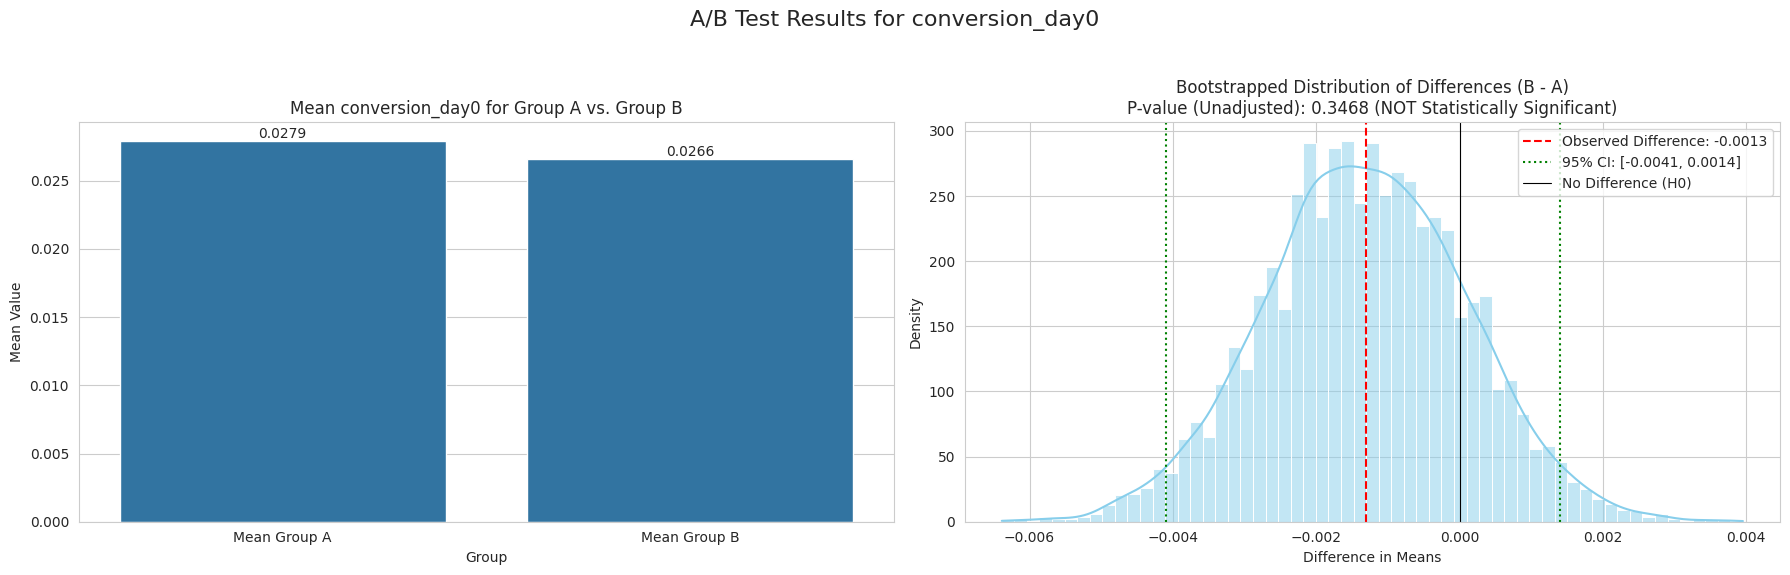

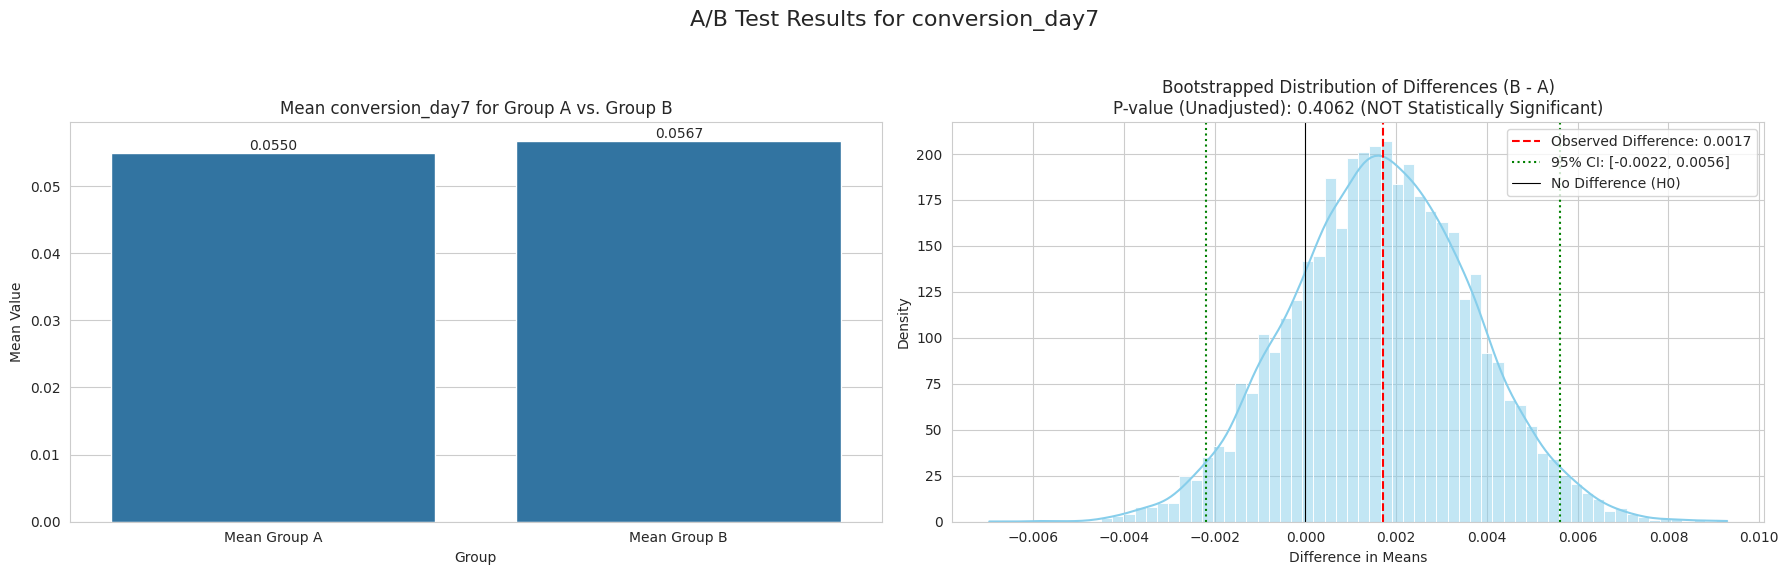

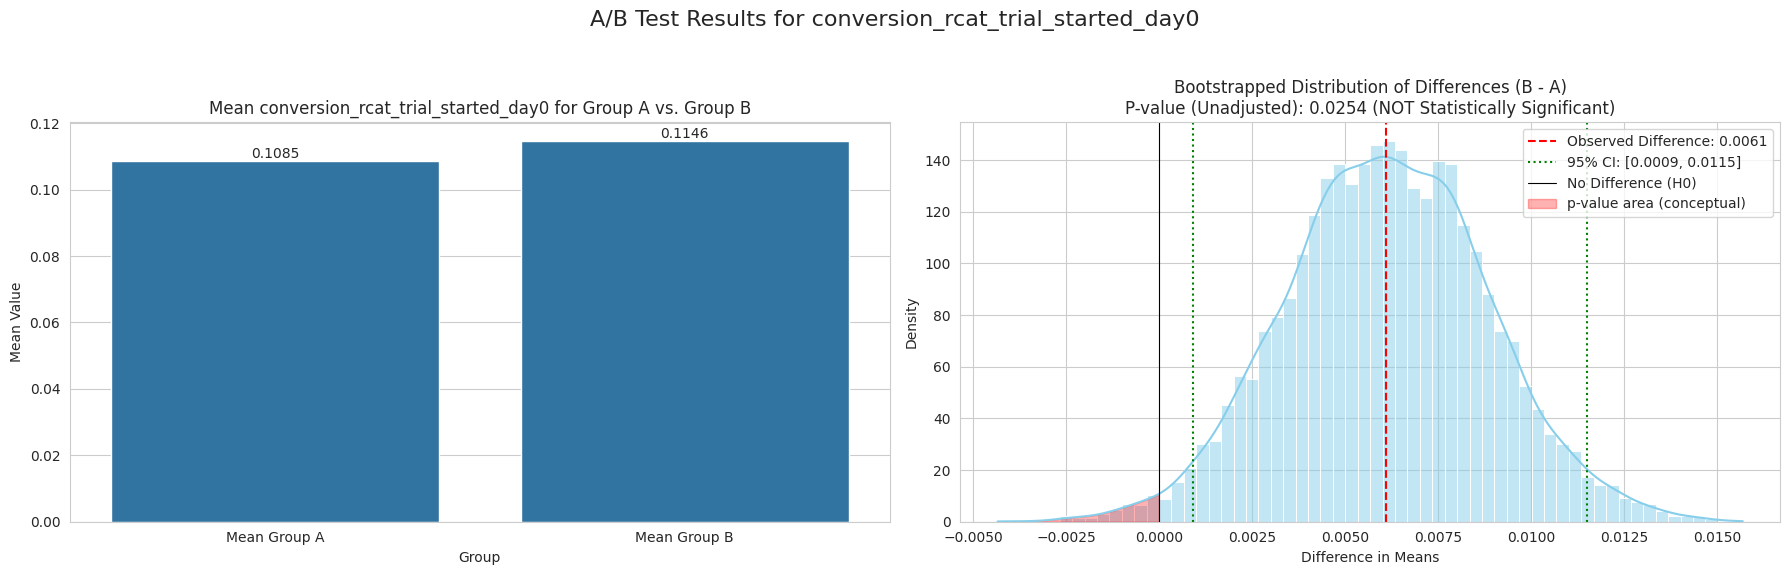

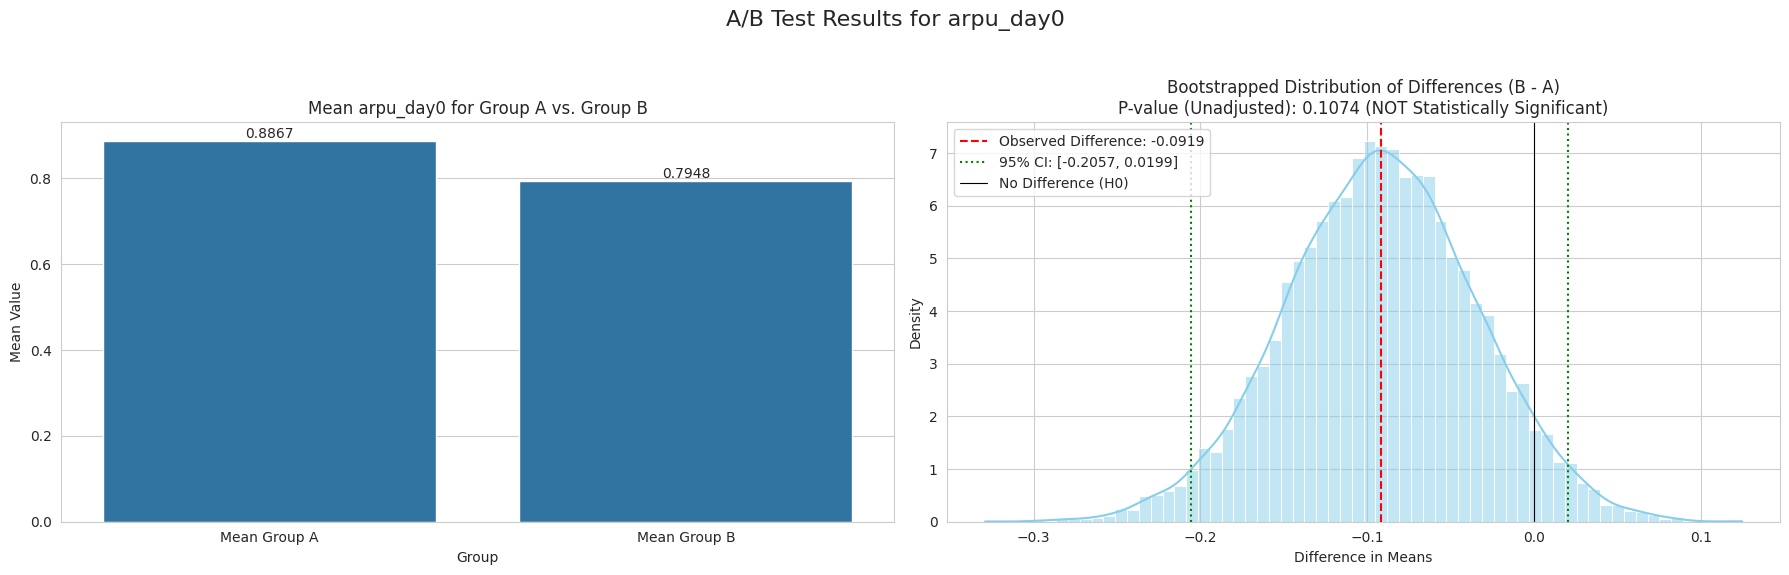

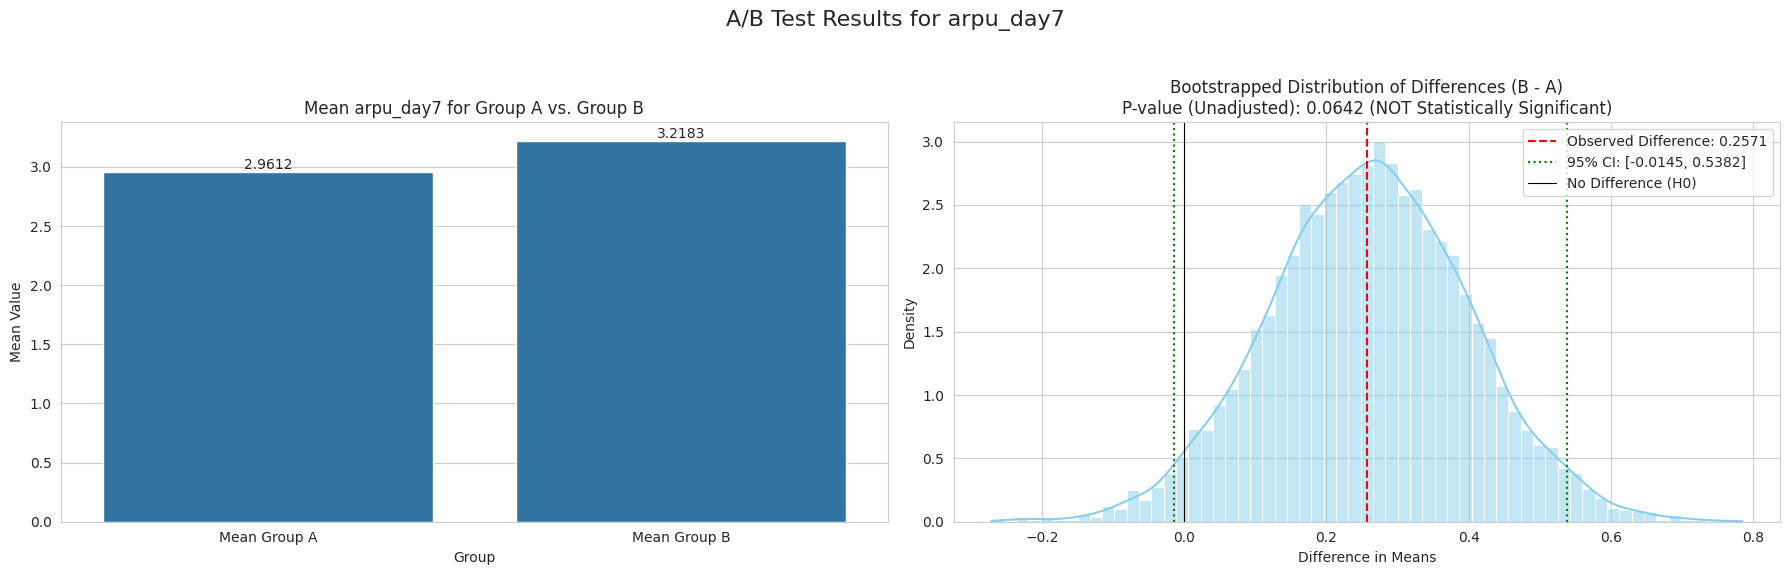

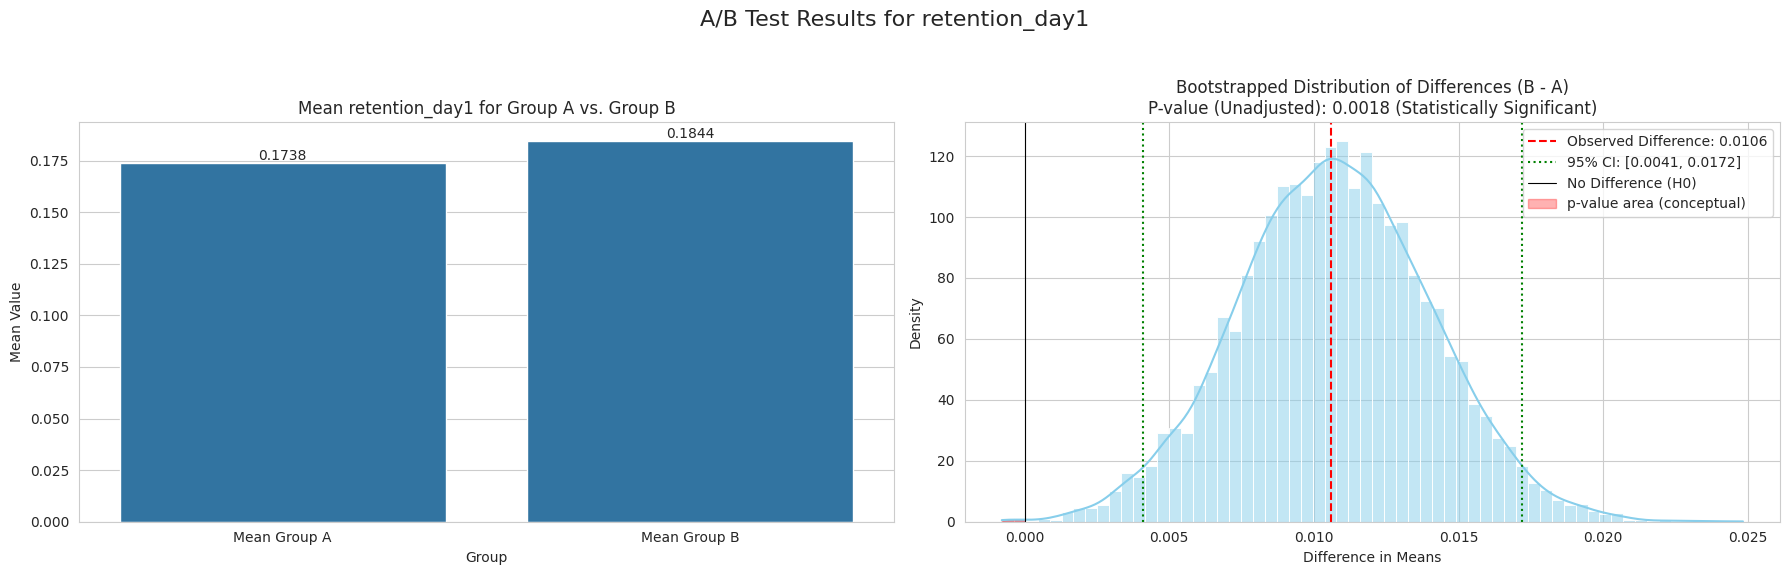

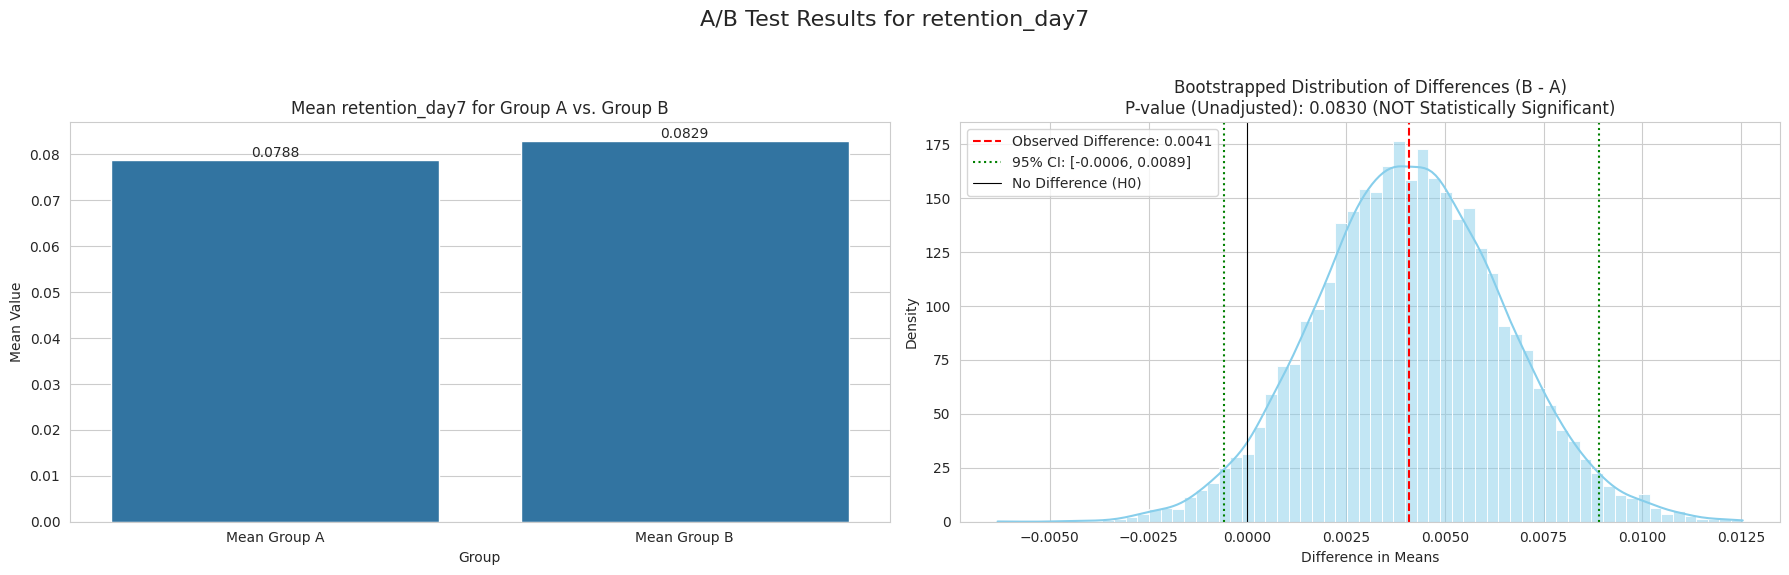

Visualizations for all metrics have been generated.


In [87]:
# This cell generates and displays visualizations for each A/B tested metric.
# It creates bar plots to compare group means and KDE plots to show the distribution of bootstrapped differences,
# including confidence intervals and unadjusted p-values with numerical labels on bars.
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Set plotting style
sns.set_style('whitegrid')

# Create a melted DataFrame for easier plotting of mean values
summary_df_melted = summary_df.melt(id_vars=['Metric'],
                                    value_vars=['Mean Group A', 'Mean Group B'],
                                    var_name='Group', value_name='Mean Value')

# Loop through each metric to create visualizations
for index, row in summary_df.iterrows():
    metric_name = row['Metric']
    observed_diff = row['Observed Difference (B-A)']
    lower_ci = row['Lower CI (Diff)']
    upper_ci = row['Upper CI (Diff)']
    p_value = row['P-value'] # Using the unadjusted P-value for visualization
    is_significant = row['Statistically Significant']

    # Retrieve the bootstrapped differences for the current metric from the original 'results' list
    # Note: 'results' contains the 'Bootstrapped Differences' list for each metric
    bootstrapped_diffs_for_metric = None
    for res in results:
        if res['Metric'] == metric_name:
            bootstrapped_diffs_for_metric = res['Bootstrapped Differences']
            break

    if bootstrapped_diffs_for_metric is None:
        print(f"Warning: Bootstrapped differences not found for {metric_name}. Skipping visualization.")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'A/B Test Results for {metric_name}', fontsize=16)

    # Plot 1: Mean comparison for Group A and Group B
    metric_melted = summary_df_melted[summary_df_melted['Metric'] == metric_name]
    sns.barplot(x='Group', y='Mean Value', data=metric_melted, ax=axes[0])
    axes[0].set_title(f'Mean {metric_name} for Group A vs. Group B')
    axes[0].set_ylabel('Mean Value')
    axes[0].set_xlabel('Group')

    # Add numerical labels on the bars
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.4f')

    # Plot 2: Distribution of Bootstrapped Differences (B - A)
    sns.histplot(bootstrapped_diffs_for_metric, kde=True, ax=axes[1], color='skyblue', stat='density')
    axes[1].axvline(x=observed_diff, color='red', linestyle='--', label=f'Observed Difference: {observed_diff:.4f}')
    axes[1].axvline(x=lower_ci, color='green', linestyle=':', label=f'95% CI: [{lower_ci:.4f}, {upper_ci:.4f}]')
    axes[1].axvline(x=upper_ci, color='green', linestyle=':')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8, label='No Difference (H0)')

    # Shade the areas for p-value calculation if needed (visual approximation)
    # For a two-sided test, we highlight areas in both tails beyond the observed difference if 0 is outside CI
    # This shading is conceptual for visualization, the actual p-value is calculated in the bootstrap function.

    # Get the KDE curve values
    kde = gaussian_kde(bootstrapped_diffs_for_metric)
    x_for_kde = np.linspace(min(bootstrapped_diffs_for_metric), max(bootstrapped_diffs_for_metric), 500)
    y_for_kde = kde(x_for_kde)

    # Highlight areas for p-value (if 0 is outside the CI)
    # This is a conceptual shading, not an exact p-value visualization
    if 0 < lower_ci or 0 > upper_ci:
        if observed_diff > 0: # Group B is better, so look at left tail
            idx_left_tail = x_for_kde <= 0
            axes[1].fill_between(x_for_kde[idx_left_tail], 0, y_for_kde[idx_left_tail], color='red', alpha=0.3, label='p-value area (conceptual)')
        elif observed_diff < 0: # Group A is better, so look at right tail
            idx_right_tail = x_for_kde >= 0
            axes[1].fill_between(x_for_kde[idx_right_tail], 0, y_for_kde[idx_right_tail], color='red', alpha=0.3, label='p-value area (conceptual)')

    sig_text = "Statistically Significant" if is_significant else "NOT Statistically Significant"
    axes[1].set_title(f'Bootstrapped Distribution of Differences (B - A)\nP-value (Unadjusted): {p_value:.4f} ({sig_text})') # Updated title
    axes[1].set_xlabel('Difference in Means')
    axes[1].set_ylabel('Density')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print("Visualizations for all metrics have been generated.")

**Reasoning**:
The visualizations for all metrics have been generated. The next logical step is to provide a comprehensive conclusion based on the A/B test results, including statistical significance and practical implications, by iterating through the `summary_df`.



In [88]:
# This cell prints detailed textual conclusions and practical implications for each A/B tested metric,
# based on their mean values, observed differences, uplift, confidence intervals, and adjusted p-values.
print("\n--- A/B Test Conclusions ---")
for index, row in summary_df.iterrows():
    metric = row['Metric']
    mean_a = row['Mean Group A']
    mean_b = row['Mean Group B']
    observed_diff = row['Observed Difference (B-A)']
    uplift = row['Uplift (%)']
    lower_ci = row['Lower CI (Diff)']
    upper_ci = row['Upper CI (Diff)']
    p_value = row['Adjusted P-value']
    is_significant = row['Statistically Significant']

    print(f"\nMetric: {metric}")
    print(f"  Mean Group A: {mean_a:.4f}")
    print(f"  Mean Group B: {mean_b:.4f}")
    print(f"  Observed Difference (B-A): {observed_diff:.4f}")
    print(f"  Uplift (%): {uplift:.2f}%")
    print(f"  95% CI for Difference: [{lower_ci:.4f}, {upper_ci:.4f}]")
    print(f"  Adjusted P-value: {p_value:.4f}")
    print(f"  Statistically Significant (alpha=0.05): {is_significant}")

    if is_significant:
        print("  Conclusion: The difference is statistically significant. Group B shows a meaningful difference compared to Group A.")
        if observed_diff > 0:
            print(f"  Practical Implication: Group B performs better than Group A with an uplift of {uplift:.2f}%. Both means {mean_a:.4f} and {mean_b:.4f} are displayed above.")
        else:
            print(f"  Practical Implication: Group A performs better than Group B with a decrease (negative uplift) of {uplift:.2f}% for Group B. Both means {mean_a:.4f} and {mean_b:.4f} are displayed above.")
    else:
        print("  Conclusion: The difference is NOT statistically significant. There is no strong evidence to suggest a meaningful difference between Group A and Group B.")
        print("  Practical Implication: The observed difference could be due to random chance. Further investigation or more data may be needed.")


--- A/B Test Conclusions ---

Metric: conversion_day0
  Mean Group A: 0.0279
  Mean Group B: 0.0266
  Observed Difference (B-A): -0.0013
  Uplift (%): -4.76%
  95% CI for Difference: [-0.0041, 0.0014]
  Adjusted P-value: 0.4046
  Statistically Significant (alpha=0.05): False
  Conclusion: The difference is NOT statistically significant. There is no strong evidence to suggest a meaningful difference between Group A and Group B.
  Practical Implication: The observed difference could be due to random chance. Further investigation or more data may be needed.

Metric: conversion_day7
  Mean Group A: 0.0550
  Mean Group B: 0.0567
  Observed Difference (B-A): 0.0017
  Uplift (%): 3.04%
  95% CI for Difference: [-0.0022, 0.0056]
  Adjusted P-value: 0.4062
  Statistically Significant (alpha=0.05): False
  Conclusion: The difference is NOT statistically significant. There is no strong evidence to suggest a meaningful difference between Group A and Group B.
  Practical Implication: The observed 

In [89]:
# This cell converts the A/B test summary DataFrame into a Markdown-formatted string for easy display or export.
summary_markdown = summary_df.to_markdown(index=False)
print("DataFrame converted to Markdown format:")
print(summary_markdown)

DataFrame converted to Markdown format:
| Metric                             |   Mean Group A |   Mean Group B |   Observed Difference (B-A) |   Uplift (%) |   Lower CI (Diff) |   Upper CI (Diff) |   P-value |   Adjusted P-value | Statistically Significant   |
|:-----------------------------------|---------------:|---------------:|----------------------------:|-------------:|------------------:|------------------:|----------:|-------------------:|:----------------------------|
| conversion_day0                    |         0.0279 |         0.0266 |                     -0.0013 |      -4.7642 |           -0.0041 |            0.0014 |    0.3468 |             0.4046 | False                       |
| conversion_day7                    |         0.055  |         0.0567 |                      0.0017 |       3.0445 |           -0.0022 |            0.0056 |    0.4062 |             0.4062 | False                       |
| conversion_rcat_trial_started_day0 |         0.1085 |         0.1146 |    

In [90]:
# This cell installs the 'fpdf' Python library, which is used for generating PDF documents.
pip install fpdf

SyntaxError: invalid syntax (ipython-input-283737690.py, line 2)

In [91]:
# This cell calculates and prints the number of unique users found in Group A and Group B.
unique_users_a = len(users_group_a)
unique_users_b = len(users_group_b)

print(f"Number of unique users in Group A: {unique_users_a}")
print(f"Number of unique users in Group B: {unique_users_b}")

Number of unique users in Group A: 26568
Number of unique users in Group B: 26651


In [92]:
# This cell generates and saves visualizations for each A/B tested metric as PNG image files.
# Each visualization includes a bar plot of group means and a KDE plot of bootstrapped differences.
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Set plotting style
sns.set_style('whitegrid')

# Create a melted DataFrame for easier plotting of mean values
summary_df_melted = summary_df.melt(id_vars=['Metric'],
                                    value_vars=['Mean Group A', 'Mean Group B'],
                                    var_name='Group', value_name='Mean Value')

# Loop through each metric to create visualizations and save them
for index, row in summary_df.iterrows():
    metric_name = row['Metric']
    observed_diff = row['Observed Difference (B-A)']
    lower_ci = row['Lower CI (Diff)']
    upper_ci = row['Upper CI (Diff)']
    p_value = row['P-value'] # Using the unadjusted P-value for visualization
    is_significant = row['Statistically Significant']

    # Retrieve the bootstrapped differences for the current metric from the original 'results' list
    bootstrapped_diffs_for_metric = None
    for res in results:
        if res['Metric'] == metric_name:
            bootstrapped_diffs_for_metric = res['Bootstrapped Differences']
            break

    if bootstrapped_diffs_for_metric is None:
        print(f"Warning: Bootstrapped differences not found for {metric_name}. Skipping visualization.")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'A/B Test Results for {metric_name}', fontsize=16)

    # Plot 1: Mean comparison for Group A and Group B
    metric_melted = summary_df_melted[summary_df_melted['Metric'] == metric_name]
    sns.barplot(x='Group', y='Mean Value', data=metric_melted, ax=axes[0])
    axes[0].set_title(f'Mean {metric_name} for Group A vs. Group B')
    axes[0].set_ylabel('Mean Value')
    axes[0].set_xlabel('Group')

    # Add numerical labels on the bars
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.4f')

    # Plot 2: Distribution of Bootstrapped Differences (B - A)
    sns.histplot(bootstrapped_diffs_for_metric, kde=True, ax=axes[1], color='skyblue', stat='density')
    axes[1].axvline(x=observed_diff, color='red', linestyle='--', label=f'Observed Difference: {observed_diff:.4f}')
    axes[1].axvline(x=lower_ci, color='green', linestyle=':', label=f'95% CI: [{lower_ci:.4f}, {upper_ci:.4f}]')
    axes[1].axvline(x=upper_ci, color='green', linestyle=':')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8, label='No Difference (H0)')

    # Get the KDE curve values
    kde = gaussian_kde(bootstrapped_diffs_for_metric)
    x_for_kde = np.linspace(min(bootstrapped_diffs_for_metric), max(bootstrapped_diffs_for_metric), 500)
    y_for_kde = kde(x_for_kde)

    # Highlight areas for p-value (if 0 is outside the CI)
    if 0 < lower_ci or 0 > upper_ci:
        if observed_diff > 0: # Group B is better, so look at left tail
            idx_left_tail = x_for_kde <= 0
            axes[1].fill_between(x_for_kde[idx_left_tail], 0, y_for_kde[idx_left_tail], color='red', alpha=0.3, label='p-value area (conceptual)')
        elif observed_diff < 0: # Group A is better, so look at right tail
            idx_right_tail = x_for_kde >= 0
            axes[1].fill_between(x_for_kde[idx_right_tail], 0, y_for_kde[idx_right_tail], color='red', alpha=0.3, label='p-value area (conceptual)')

    sig_text = "Statistically Significant" if is_significant else "NOT Statistically Significant"
    axes[1].set_title(f'Bootstrapped Distribution of Differences (B - A)\nP-value (Unadjusted): {p_value:.4f} ({sig_text})') # Updated title
    axes[1].set_xlabel('Difference in Means')
    axes[1].set_ylabel('Density')
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap

    # Save the figure
    image_filename = f'ab_test_visualization_{metric_name}.png'
    plt.savefig(image_filename)
    # plt.show() # Commented out to prevent displaying plots in the notebook
    plt.close(fig) # Close the figure to free up memory

print("Visualizations for all metrics have been generated and saved as PNG files.")

Visualizations for all metrics have been generated and saved as PNG files.


In [93]:
# This cell generates a comprehensive PDF report combining A/B test results.
# It includes a summary table, user counts, detailed conclusions, and embedded visualization images.
import os
from fpdf import FPDF

def add_markdown_table_to_pdf(pdf, markdown_table_string, col_widths=None, cell_height=8):
    """
    Adds a Markdown table string to the PDF document with customizable column widths.
    Automatically calculates uniform widths if col_widths is not provided.
    """
    lines = markdown_table_string.strip().split('\n')
    if not lines or len(lines) < 2: # Need at least header and separator
        return

    # Extract headers and data
    headers = [h.strip() for h in lines[0].strip('|').split('|')]
    data_rows = []
    for line in lines[2:]: # Skip header and separator line
        if line.strip():
            data_rows.append([d.strip() for d in line.strip('|').split('|')])

    num_cols = len(headers)

    # Calculate column widths if not provided or validate provided widths
    if col_widths is None:
        total_available_width = pdf.w - pdf.l_margin - pdf.r_margin
        col_width_uniform = total_available_width / num_cols
        col_widths = [col_width_uniform] * num_cols
    elif len(col_widths) != num_cols:
        print(f"Warning: Number of provided column widths ({len(col_widths)}) does not match number of columns ({num_cols}). Recalculating uniform widths.")
        total_available_width = pdf.w - pdf.l_margin - pdf.r_margin
        col_width_uniform = total_available_width / num_cols
        col_widths = [col_width_uniform] * num_cols

    # Store current X position to reset after each row
    start_x = pdf.get_x()

    # Add headers
    pdf.set_font('Arial', 'B', 9) # Slightly smaller font for headers to fit
    for i, header in enumerate(headers):
        pdf.cell(col_widths[i], cell_height, header, border=1, align='C') # Use cell instead of multi_cell
    pdf.ln(cell_height) # Move to next line for data rows

    # Add data rows
    pdf.set_font('Arial', '', 7) # Smaller font for data to fit
    for row_data in data_rows:
        pdf.set_x(start_x) # Reset X position for each new row
        for i, item in enumerate(row_data):
            pdf.cell(col_widths[i], cell_height, item, border=1, align='C') # Use cell instead of multi_cell
        pdf.ln(cell_height) # Move to next line for the next row

# Create instance of FPDF class in landscape mode
pdf = FPDF('L', 'mm', 'A4')
pdf.add_page()
pdf.set_auto_page_break(auto=True, margin=15)

# --- Add Main Title ---
pdf.set_font('Arial', 'B', 18)
pdf.cell(0, 10, 'A/B Test Results Report', 0, 1, 'C')
pdf.ln(10)

# --- Add User Group Counts ---
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'User Group Sizes', 0, 1, 'L')
pdf.ln(5)
pdf.set_font('Arial', '', 10)
pdf.multi_cell(0, 7, f"Number of unique users in Group A: {unique_users_a}")
pdf.multi_cell(0, 7, f"Number of unique users in Group B: {unique_users_b}")
pdf.ln(10)

# --- Add Summary Table ---
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'Summary Table of A/B Test Results', 0, 1, 'L')
pdf.ln(5)

# Define custom column widths for the summary_df (10 columns)
# Total A4 landscape width = 297mm. Margins approx 10mm each side, so usable width = 277mm.
custom_col_widths = [
    40, # Metric
    25, # Mean Group A
    25, # Mean Group B
    30, # Observed Difference (B-A)
    20, # Uplift (%)
    25, # Lower CI (Diff)
    25, # Upper CI (Diff)
    20, # P-value
    25, # Adjusted P-value
    25  # Statistically Significant
]
# Total: 40+25+25+30+20+25+25+20+25+25 = 260mm. Fits within 277mm.

add_markdown_table_to_pdf(pdf, summary_markdown, col_widths=custom_col_widths)
pdf.ln(10)

# --- Add Detailed Conclusions ---
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'Detailed Conclusions', 0, 1, 'L')
pdf.ln(5)

pdf.set_font('Arial', '', 10)
for index, row in summary_df.iterrows():
    metric = row['Metric']
    mean_a = row['Mean Group A']
    mean_b = row['Mean Group B']
    observed_diff = row['Observed Difference (B-A)']
    uplift = row['Uplift (%)']
    lower_ci = row['Lower CI (Diff)']
    upper_ci = row['Upper CI (Diff)']
    p_value = row['Adjusted P-value']
    is_significant = row['Statistically Significant']

    # Check for page break before adding new metric's conclusion
    if pdf.get_y() + 80 > pdf.h - pdf.b_margin: # Estimate height needed for one conclusion block
        pdf.add_page()
        pdf.set_font('Arial', 'B', 14)
        pdf.cell(0, 10, 'Detailed Conclusions (Continued)', 0, 1, 'L')
        pdf.ln(5)
        pdf.set_font('Arial', '', 10)

    pdf.multi_cell(0, 5, f"Metric: {metric}")
    pdf.multi_cell(0, 5, f"  Mean Group A: {mean_a:.4f}")
    pdf.multi_cell(0, 5, f"  Mean Group B: {mean_b:.4f}")
    pdf.multi_cell(0, 5, f"  Observed Difference (B-A): {observed_diff:.4f}")
    pdf.multi_cell(0, 5, f"  Uplift (%): {uplift:.2f}%")
    pdf.multi_cell(0, 5, f"  95% CI for Difference: [{lower_ci:.4f}, {upper_ci:.4f}]")
    pdf.multi_cell(0, 5, f"  Adjusted P-value: {p_value:.4f}")
    pdf.multi_cell(0, 5, f"  Statistically Significant (alpha=0.05): {is_significant}")

    if is_significant:
        pdf.multi_cell(0, 5, "  Conclusion: The difference is statistically significant. Group B shows a meaningful difference compared to Group A.")
        if observed_diff > 0:
            pdf.multi_cell(0, 5, f"  Practical Implication: Group B performs better than Group A with an uplift of {uplift:.2f}%. Both means {mean_a:.4f} and {mean_b:.4f} are displayed above.")
        else:
            pdf.multi_cell(0, 5, f"  Practical Implication: Group A performs better than Group B with a decrease (negative uplift) of {uplift:.2f}% for Group B. Both means {mean_a:.4f} and {mean_b:.4f} are displayed above.")
    else:
        pdf.multi_cell(0, 5, "  Conclusion: The difference is NOT statistically significant. There is no strong evidence to suggest a meaningful difference between Group A and Group B.")
        pdf.multi_cell(0, 5, "  Practical Implication: The observed difference could be due to random chance. Further investigation or more data may be needed.")
    pdf.ln(5)

# --- Add Visualizations ---
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'Visualizations', 0, 1, 'L')
pdf.ln(5)

# Image dimensions and positioning
image_width = 250 # mm, to fit comfortably in landscape A4 (297mm total width)
image_height = 80 # mm, adjusted for aspect ratio and page space
x_center = (pdf.w - image_width) / 2 # Center horizontally

pdf.set_font('Arial', 'B', 12)
for index, row in summary_df.iterrows():
    metric = row['Metric']
    image_filename = f'ab_test_visualization_{metric}.png'

    if os.path.exists(image_filename):
        # Check if there's enough vertical space for the image and its title
        if pdf.get_y() + image_height + 20 > pdf.h - pdf.b_margin: # 20mm for title and spacing
            pdf.add_page()
            pdf.set_font('Arial', 'B', 14)
            pdf.cell(0, 10, 'Visualizations (Continued)', 0, 1, 'L')
            pdf.ln(5)
            pdf.set_font('Arial', 'B', 12)

        # Add metric subtitle
        pdf.cell(0, 10, f'Metric: {metric}', 0, 1, 'L')
        pdf.ln(2)
        # Add image, centered
        pdf.image(image_filename, x=x_center, w=image_width, h=image_height)
        pdf.ln(image_height + 5) # Move cursor below the image with some spacing
    else:
        pdf.set_font('Arial', '', 10)
        pdf.multi_cell(0, 5, f"Warning: Image file '{image_filename}' not found for metric '{metric}'.")
        pdf.ln(5)

# Save the PDF
pdf.output('ab_test_report.pdf')
print("PDF report 'ab_test_report.pdf' generated successfully with all requested elements.")

PDF report 'ab_test_report.pdf' generated successfully with all requested elements.
